In [ ]:
import os
import glob
import sklearn
import pandas as pd
import numpy as np
import gdal
from google.colab import drive
from google.colab import auth
from sklearn.model_selection import train_test_split
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.ensemble import RandomForestClassifier
auth.authenticate_user()
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1. Reading geotiff file and samples**

In [ ]:
#function to read geotiff
def readtiff(filename):
    # @ file name to read
    file = gdal.Open(filename, gdal.GA_ReadOnly)
    band_number = file.RasterCount
    #print(band_number)
    #data = file.GetRasterBand(0,23)
    #print(data)
    array = file.ReadAsArray()
    return array

In [ ]:
#read RS data
RS_file = '/content/drive/MyDrive/Senior Design/Competition /Dataset/Competition_Dataset/LK/LK_NDVI.tif'
array_NDVI = readtiff(RS_file)
array_shape = array_NDVI.shape
array_result = np.zeros((array_shape[1],array_shape[2]),dtype=int)
file_geo = gdal.Open(RS_file, gdal.GA_ReadOnly)

In [ ]:
df_crop = pd.read_csv('/content/drive/MyDrive/Senior Design/Competition /Samples/SR_samples/SR_cropland_samples.csv', sep=',', header=None)
df_crop = df_crop.drop([0, 25], axis=1)
new_header = df_crop.iloc[0]
df_crop = df_crop[1:] 
df_crop.columns = new_header
df_noncrop = pd.read_csv('/content/drive/MyDrive/Senior Design/Competition /Samples/SR_samples/SR_noncropland_samples.csv', sep=',', header=None)
df_noncrop = df_noncrop.drop([0, 25], axis=1)
new_header = df_noncrop.iloc[0]
df_noncrop = df_noncrop[1:] 
df_noncrop.columns = new_header

# **2. Pre-processing and NDVI reconstruction**

In [ ]:
from scipy.signal import savgol_filter
def ndvi_reconstruct(df):
  for i in range(len(df)):
    smoothed_NDVI = savgol_filter(df.iloc[i], window_length = 3, polyorder = 2)
    df.iloc[i] = smoothed_NDVI
    for j in range(len(df.columns)-1):
       if df.iat[i,j] == 0 or  abs(df.iat[i,j-1] - df.iat[i,j]) > 4000 :
              df.iat[i,j] = ((df.iloc[i][1]+df.iloc[i][len(df.columns)-1])/2.0)
       if j == len(df.columns)-1:
                df.iat[i,j] = ((df.iloc[i][j-1]+df.iloc[i][0])/2.0)
       if j != 0 and j != len(df.columns) - 1:
                df.iat[i,j] = ((df.iloc[i][j-1]+df.iloc[i][j+1])/2.0)
  return df

In [ ]:
from sklearn import preprocessing
def normalize(df):
  scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
  names = df.columns
  d = scaler.fit_transform(df)
  scaled_df = pd.DataFrame(d, columns=names)
  return scaled_df

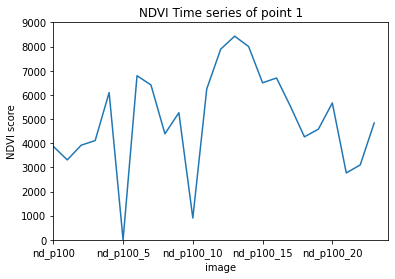

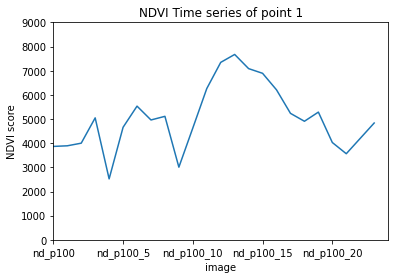

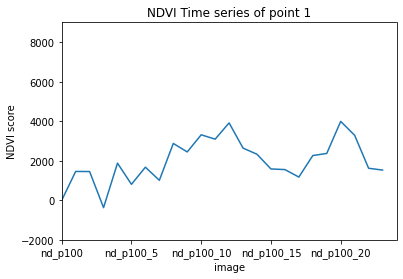

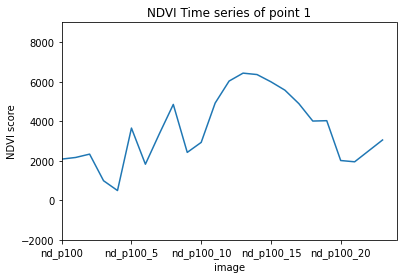

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
series = df_crop.astype(float).iloc[1]
series.plot()
plt.title("NDVI Time series of point 1")
plt.xlabel("image")
plt.ylabel("NDVI score")
plt.ylim([0, 9000])
plt.xlim([0, 24])
pyplot.show()
df_crop = df_crop.astype(float)
df_crop = ndvi_reconstruct(df_crop)
series = df_crop.iloc[1]
series.plot()
plt.title("NDVI Time series of point 1")
plt.xlabel("image")
plt.ylabel("NDVI score")
plt.ylim([0, 9000])
plt.xlim([0, 24])
pyplot.show()

series = df_noncrop.astype(float).iloc[20]
series.plot()
plt.title("NDVI Time series of point 1")
plt.xlabel("image")
plt.ylabel("NDVI score")
plt.ylim([-2000, 9000])
plt.xlim([0, 24])
pyplot.show()
df_noncrop = df_noncrop.astype(float)
df_noncrop = ndvi_reconstruct(df_noncrop)
series = df_noncrop.iloc[1]
series.plot()
plt.title("NDVI Time series of point 1")
plt.xlabel("image")
plt.ylabel("NDVI score")
plt.ylim([-2000, 9000])
plt.xlim([0, 24])
pyplot.show()

In [ ]:
df_crop = ndvi_reconstruct(df_crop.astype(float))
#df_crop = normalize(df_crop)
df_crop['class'] = 1
df_noncrop = ndvi_reconstruct(df_noncrop.astype(float))
#df_noncrop = normalize(df_noncrop)
df_noncrop['class'] = 0
df = pd.concat([df_crop, df_noncrop])
df = df.sample(frac = 1).reset_index(drop=True)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics 
x=df.drop(["class"], axis = 1);
y=df["class"]
x_train=[]
y_train=[]
x_test=[]
y_test=[]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=True )
x_train=np.array(x_train).astype('int').reshape(100,24)
y_train=np.array(y_train).astype('int').reshape(100)
x_test=np.array(x_test).astype('int').reshape(50,24)
y_test=np.array(y_test).astype('int').reshape(50)


In [ ]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(100).fit(x_train, y_train)
expected_y  = y_test
predicted_y = rf.predict(x_test)
print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84        20
           1       0.93      0.83      0.88        30

    accuracy                           0.86        50
   macro avg       0.85      0.87      0.86        50
weighted avg       0.87      0.86      0.86        50

[[18  2]
 [ 5 25]]


In [ ]:
pip install geemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 37.8 MB/s 
     |████████████████████████████████| 198 kB 54.2 MB/s 
     |████████████████████████████████| 1.3 MB 66.3 MB/s 
     |████████████████████████████████| 130 kB 56.4 MB/s 
     |████████████████████████████████| 8.8 MB 50.9 MB/s 
     |████████████████████████████████| 99 kB 9.2 MB/s 
     |████████████████████████████████| 98 kB 8.2 MB/s 
     |████████████████████████████████| 3.0 MB 51.0 MB/s 
     |████████████████████████████████| 3.4 MB 62.2 MB/s 
     |████████████████████████████████| 46 kB 3.6 MB/s 
     |████████████████████████████████| 1.2 MB 53.5 MB/s 
     |████████████████████████████████| 55 kB 4.3 MB/s 
     |████████████████████████████████| 128 kB 73.2 MB/s 
     |████████████████████████████████| 1.6 MB 54.1 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 4

In [ ]:
import geemap
import ee
from geemap import ml
geemap.ee_initialize()

bands = ['nd_p100','nd_p100_1','nd_p100_2','nd_p100_3','nd_p100_4','nd_p100_5','nd_p100_6','nd_p100_7','nd_p100_8','nd_p100_9','nd_p100_10','nd_p100_11','nd_p100_12','nd_p100_13','nd_p100_14','nd_p100_15','nd_p100_16','nd_p100_17','nd_p100_18','nd_p100_19','nd_p100_20','nd_p100_21','nd_p100_22','nd_p100_23']
label = "class"

image = ee.Image('projects/ee-g00085636/assets/NDVI_SRI_LANKA_unmasked') #IRAN

In [ ]:
trees = ml.rf_to_strings(rf, bands)
ee_classifier = ml.strings_to_classifier(trees)
classified = image.select(bands).classify(ee_classifier)
Map = geemap.Map(center=(80.5,8.5),zoom=10)

Map.addLayer(
    image,
    {"bands": ['nd_p100_2','nd_p100_5','nd_p100_7'], "min": -10000, "max": 10000, "gamma": 1.5},
    'image',
)
Map.addLayer(
    classified,
    { "palette": ['#444444', '#e49635']},
    'classification',
)
Map

Map(center=[80.5, 8.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(…

In [ ]:
df_crop = pd.read_csv('/content/drive/MyDrive/Senior Design/Competition /Samples/SR_samples/SR_cropland_samples.csv', sep=',', header=None)
df_crop = df_crop.drop([0, 25], axis=1)
new_header = df_crop.iloc[0]
df_crop = df_crop[1:] 
df_crop.columns = new_header
df_noncrop = pd.read_csv('/content/drive/MyDrive/Senior Design/Competition /Samples/SR_samples/SR_noncropland_samples.csv', sep=',', header=None)
df_noncrop = df_noncrop.drop([0, 25], axis=1)
new_header = df_noncrop.iloc[0]
df_noncrop = df_noncrop[1:] 
df_noncrop.columns = new_header

In [ ]:
df_crop = ndvi_reconstruct(df_crop.astype(float))
df_crop = normalize(df_crop)
df_crop['class'] = 1
df_noncrop = ndvi_reconstruct(df_noncrop.astype(float))
df_noncrop = normalize(df_noncrop)
df_noncrop['class'] = 0
df = pd.concat([df_crop, df_noncrop])
df = df.sample(frac = 1).reset_index(drop=True)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics 
x=df.drop(["class"], axis = 1);
y=df["class"]
x_train=[]
y_train=[]
x_test=[]
y_test=[]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=True )
x_train=np.array(x_train).astype('float').reshape(100,24)
y_train=np.array(y_train).astype('float').reshape(100)
x_test=np.array(x_test).astype('float').reshape(50,24)
y_test=np.array(y_test).astype('float').reshape(50)


In [ ]:
x_train_lstm = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_test_lstm = x_test.reshape((x_test.shape[0],x_test.shape[1],1))

In [ ]:
from keras.metrics.metrics import accuracy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

n_steps = 24
n_features = 1 
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'],)

In [ ]:
hist = model.fit(x_train_lstm, y_train, epochs=100, verbose=1)

Epoch 1/100
4/4 [==============================] - 2s 8ms/step - loss: 0.4990 - accuracy: 0.5000
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 0.4634 - accuracy: 0.5000
Epoch 3/100
4/4 [==============================] - 0s 8ms/step - loss: 0.4322 - accuracy: 0.5000
Epoch 4/100
4/4 [==============================] - 0s 8ms/step - loss: 0.4050 - accuracy: 0.5000
Epoch 5/100
4/4 [==============================] - 0s 8ms/step - loss: 0.3737 - accuracy: 0.5000
Epoch 6/100
4/4 [==============================] - 0s 10ms/step - loss: 0.3416 - accuracy: 0.5000
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 0.3071 - accuracy: 0.4600
Epoch 8/100
4/4 [==============================] - 0s 8ms/step - loss: 0.2746 - accuracy: 0.3700
Epoch 9/100
4/4 [==============================] - 0s 8ms/step - loss: 0.2616 - accuracy: 0.5500
Epoch 10/100
4/4 [==============================] - 0s 8ms/step - loss: 0.2679 - accuracy: 0.5000
Epoch 11/100
4/4 [=========

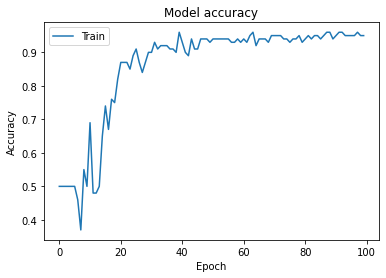

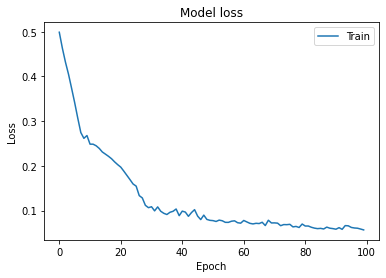

In [ ]:
plt.plot(hist.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper right') 
plt.show()

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# expected_y  = y_test
# predicted_y = model.predict(x_test_lstm, verbose=0)
scores = model.evaluate(x_test_lstm, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 90.00%


In [ ]:
import xgboost as xgb

model = xgb.XGBClassifier()
model.fit(x_train, y_train)
expected_y  = y_test
predicted_y = model.predict(x_test)
print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))

              precision    recall  f1-score   support

         0.0       0.81      1.00      0.89        25
         1.0       1.00      0.76      0.86        25

    accuracy                           0.88        50
   macro avg       0.90      0.88      0.88        50
weighted avg       0.90      0.88      0.88        50

[[25  0]
 [ 6 19]]


In [ ]:
from keras.layers import Bidirectional, Activation

model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True),
                             input_shape=(24, 1)))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='mse',
optimizer='adam',
metrics=['accuracy'])

In [ ]:
hist = model.fit(x_train_lstm, y_train, epochs = 100)

Epoch 1/100
4/4 [==============================] - 6s 31ms/step - loss: 0.2475 - accuracy: 0.5500
Epoch 2/100
4/4 [==============================] - 0s 25ms/step - loss: 0.2410 - accuracy: 0.6100
Epoch 3/100
4/4 [==============================] - 0s 24ms/step - loss: 0.2332 - accuracy: 0.6100
Epoch 4/100
4/4 [==============================] - 0s 26ms/step - loss: 0.2273 - accuracy: 0.6100
Epoch 5/100
4/4 [==============================] - 0s 24ms/step - loss: 0.2200 - accuracy: 0.6300
Epoch 6/100
4/4 [==============================] - 0s 26ms/step - loss: 0.2109 - accuracy: 0.6500
Epoch 7/100
4/4 [==============================] - 0s 24ms/step - loss: 0.2021 - accuracy: 0.6500
Epoch 8/100
4/4 [==============================] - 0s 24ms/step - loss: 0.1919 - accuracy: 0.6800
Epoch 9/100
4/4 [==============================] - 0s 30ms/step - loss: 0.1836 - accuracy: 0.7700
Epoch 10/100
4/4 [==============================] - 0s 27ms/step - loss: 0.1743 - accuracy: 0.7500
Epoch 11/100
4/4 [=

In [ ]:
scores = model.evaluate(x_test_lstm, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 80.00%


In [ ]:
# LSTM EXPORTING
# for i in range(array_shape[1]):
#   #get the data for a line
#   temp_array = array_NDVI[:,i,:]
#   temp_df = pd.DataFrame(temp_array.T)
#   temp_df.columns = pd.DataFrame(x_train).columns.tolist()
#   temp_df_test = temp_df.to_numpy()
#   temp_df_test = temp_df_test.reshape((temp_df_test.shape[0],temp_df_test.shape[1],1))
#   predections = model.predict(temp_df_test)


#RandomForest EXPORTING

for i in range(array_shape[1]):
  #get the data for a line
  temp_array = array_NDVI[:,i,:]
  temp_df = pd.DataFrame(temp_array.T)
  temp_df.columns = pd.DataFrame(x_train).columns.tolist() #unnormalized_x_train (CAUTIONS) 
  array_result[i,:] = rf.predict(temp_df)

In [ ]:
Output_file = '/content/drive/MyDrive/results/Cropland_extent_SR_smooth.tif' #change
driver = gdal.GetDriverByName('Gtiff')
outRaster = driver.Create(Output_file, file_geo.RasterXSize, file_geo.RasterYSize, 1, gdal.GDT_Byte)
outRaster.SetGeoTransform(file_geo.GetGeoTransform())
outRaster.SetProjection(file_geo.GetProjection())
outRaster.GetRasterBand(1).WriteArray(array_result)
outRaster = None